# OPTIMIZATION FOR DATA SCIENCE 2021-2022 - SCP7079229: First Homework

Group : Casarella Cecilia (2054536), Pellizzari Giulia (2054535), Repetto Sara (2055518).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from numpy import linalg as LA
import time 
from sklearn.metrics import accuracy_score


n = 5000
labels = 150

###Generation of 2D linearly separable points 
*Parameters*

*   𝑛 : number of examples of one cluster.
*   𝑛*2 : total number of training examples, in this case 10000.
*   **labels** : number of labeled examples in one cluster, therefore labels*2 is the total number of labeled examples in order to perform the semi-supervised learning task. In this case we labeled 3% of our data.
*   **x_j** : the matrix (n\*2 - labels*2, 2) contains the coordinates of the unlabeled points.
*   **y_j**: the vector contains the true labels of the unlabeled examples. This vector is only used in order to calculate the accuracy of the trained algorithms.
*   **x_i** : the matrix (lables*2, 2) contains the coordinates of the labeled points.
*   **y_i**: the vector contains the true labels of the labeled examples. This vector is used to quantify the objective function value.





In [ ]:
#n : data of one cluster (n*2 all points)
#labels : number of labeled examples (3%)
def data_generation(n, labels):
  center1 = (50, 60)
  center2 = (80, 20)
  distance = 20

  x1 = np.random.uniform(center1[0], center1[0] + distance, size=(n,))
  f_x_1 = np.random.normal(center1[1], distance, size=(n,))

  x2 = np.random.uniform(center2[0], center2[0] + distance, size=(n,))
  f_x_2 = np.random.normal(center2[1], distance, size=(n,)) 

  y_i = np.array([-1] * labels + [1] * labels)
  y_j = np.array([-1] * (n - labels) + [1] * (n - labels))

  x_i = np.vstack((
    np.concatenate((x1[:labels], x2[:labels])),
    np.concatenate((f_x_1[:labels], f_x_2[:labels])),
  )).T

  x_j = np.vstack((
    np.concatenate((x1[labels:], x2[labels:])),
    np.concatenate((f_x_1[labels:], f_x_2[labels:])),
  )).T


  plt.figure(figsize=(15, 10))
  plt.scatter(x1, f_x_1)
  plt.scatter(x2, f_x_2)
  plt.show()

  return y_i,y_j,x_i,x_j

In [ ]:
# 1. variance of Wavelet Transformed image (continuous)
# 2. skewness of Wavelet Transformed image (continuous)
# 3. curtosis of Wavelet Transformed image (continuous)
# 4. entropy of image (continuous)
# 5. class (integer)

In [ ]:
def data_preparation_external_db(file_path, labels):
  data = pd.read_csv(file_path,sep = ',',header= None) 
  class_1 = data[data[4]>0]
  n1 = len(class_1)
  class_0 = data[data[4]<1][:610]
  n0 = len(class_0)
  n = n0 + n1 - labels*2

  y_i = np.array([-1] * labels + [1] * labels)
  y_j = np.array([-1] * (n1 - labels) + [1] * (n0 - labels))
  x_i = np.vstack((
    np.concatenate((class_0[0][:labels], class_1[0][:labels])),
    np.concatenate((class_0[1][:labels], class_1[1][:labels])),
    np.concatenate((class_0[2][:labels], class_1[2][:labels])),
    np.concatenate((class_0[3][:labels], class_1[3][:labels])),
  )).T
  x_j = np.vstack((
    np.concatenate((class_0[0][labels:], class_1[0][labels:])),
    np.concatenate((class_0[1][labels:], class_1[1][labels:])),
    np.concatenate((class_0[2][labels:], class_1[2][labels:])),
    np.concatenate((class_0[3][labels:], class_1[3][labels:])),
  )).T

  # Separating out the features
  x = data[[0,1,2,3]].values
  # Separating out the target
  y = data[[4]].values
  # Standardizing the features
  x = StandardScaler().fit_transform(x)

  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(x)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['x', 'f_x'])
  finalDf = pd.concat([principalDf, data[4]], axis = 1)

  plt.figure(figsize=(15, 10))

  plt.scatter(np.squeeze(np.asarray(finalDf['x']))[finalDf[4] == 1], np.squeeze(np.asarray(finalDf['f_x']))[finalDf[4] == 1])
  plt.scatter(np.squeeze(np.asarray(finalDf['x']))[finalDf[4] == 0], np.squeeze(np.asarray(finalDf['f_x']))[finalDf[4] == 0])

  plt.show()

  return n,y_i,y_j,x_i,x_j

##Weights calculation 

\begin{align}
        W_{ij} = \frac{10}{Euclidean Distance(x_i,x_j) + 1}
    \end{align}

\begin{align}
        \bar{W}_{ij}= \frac{10}{Euclidean Distance(x_j,x_j) + 1}
    \end{align}



In [ ]:
def weights(x_i, x_j):
  w_ij =10/(distance_matrix(x_i, x_j, p=2) + 1).T
  w_ij_bar =10/(distance_matrix(x_j,x_j, p=2) + 1)
  return w_ij,w_ij_bar

##Objective Function

\begin{align}
        \min_{y \in ℝ^n} \sum_{i=1}^l\sum_{j=1}^u w_{ij}({y^j} - {ȳ^i})^2 + 1/2\sum_{i=1}^u\sum_{j=1}^u \bar{w}_{ij}({y^i} - {y^j})^2.
    \end{align}

In [ ]:
#Objective Function
def objective_function(w_ij, w_ij_bar,y_j,y_i):
  res1 = 0
  res2 = 0
  for i in range(len(y_i)):
    res1 += w_ij[:, i] @ ((y_j - y_i[i])*(y_j - y_i[i]))
  for j in range(len(y_j)):
    res2 += w_ij_bar[:, j] @ ((y_j - y_j[j])*(y_j - y_j[j]))
  return res1 + (res2/2)

## First Derivative

\begin{align}
        ∇_{y^j}f(x) = 2\sum_{i=1}^l w_{ij}({y^j} - {ȳ^i}) + 2\sum_{i=1}^u \bar{w}_{ij}({y^j} - {y^i}).
    \end{align}

The function *first_derivative* computes the gradient of the entire vector y_j iterating the process for each element j in y_j while the function *first_derivative_block* computes the derivative for just one element.

In [ ]:
#First Derivative
def first_derivative(W_ij,W_ij_bar, y_init, y_i):
  derivative = list()
  for j in range(len(y_j)):
    der_y_j = 2 * (W_ij[j] @ (y_init[j] - y_i)) + 2*(W_ij_bar[j] @ (y_init[j] - y_init))  
    derivative.append(der_y_j)

  return np.asarray(derivative)

In [ ]:
#First Derivative wrt block of one element
def first_derivative_block(W_ij,W_ij_bar, y_init, y_i, ind):
  der_y_j = 2 * (W_ij[ind] @ (y_init[ind] - y_i))+ 2*(W_ij_bar[ind] @ (y_init[ind] - y_init))

  return der_y_j

##Hessian Matrix and calculation of the eigenvalues

\begin{align}
          Diagonal = 2\sum_{i=1}^l w_{ij} + 2\sum_{i=1}^u \bar{w}_{ij} -2\bar{w}_{jj}\\
          Outside\ of\ diagonal = -2\bar{w}_{ij}
    \end{align}

In [ ]:
#Diagonal : 2*sum(w_i_j[j]) + 2*sum(w_ij_bar[j]) - 2
#Outside of diagonal : -2 * w_ij_bar[i][j]

In [ ]:
def hessian_matrix_eigv(w_ij, w_ij_bar, y_j):
  t = time.time()
  hessian = np.zeros((len(y_j),len(y_j)))
  for i in range(len(y_j)):
    for j in range(len(y_j)):
      if i == j:
        #Diagonal
        hessian[i][j] = (
            2*sum(w_ij[j]) + 
            2*sum(w_ij_bar[j]) - 
            2)
      else:
        #Outside
        hessian[i][j] = -2 * w_ij_bar[i][j]
  
  eigv = LA.eigvals(hessian)
  return hessian, eigv, time.time()-t

In [ ]:
def plot_results(x_j,x_i,x,y_i):
  plt.figure(figsize=(15, 10))
  plt.scatter((x_j[:,0])[x>0], (x_j[:,1])[x>0])
  plt.scatter((x_j[:,0])[x<0], (x_j[:,1])[x<0])

  plt.scatter((x_i[:,0])[y_i == 1], (x_i[:,1])[y_i == 1])
  plt.scatter((x_i[:,0])[y_i == -1], (x_i[:,1])[y_i == -1])

  plt.show()

##Gradient Descent
Notes:
1. Choice of a starting point:
$\mathbf{x}=\begin{pmatrix}
0\\
0\\
\vdots\\
0
\end{pmatrix}$

2. $α_k$ is calculated as $\dfrac{1}{L}$ where L is denoted as the Lipschitz constant of the gradient (fixed line search).


3. The update at each iteration is calculated as follows 
$x_{k + 1} = x_k + \alpha_k∇f(x_k)$ where $∇f(x_k)$ is the output of the *first_derivative* function.

4. At each iteration the value of the objective function is computed although is not required for the optimization process (it will be used in order to plot some useful results), however the CPU time used to calculate this value has been taken out from the overall CPU time.

5. The number of max possible iterations is set to 10000.




In [ ]:
def gradient_descent_method(eps,x,n,labels,maxit,eigv, w_ij, w_ij_bar,y_i, y_j):
  #iteration
  it = 0
  #CPU time for each iteration
  timeVec = np.zeros(maxit)
  #accuracy
  accuracy = np.zeros(maxit)    
  #Objective function value at each iteration
  fh = np.zeros(maxit)
  #Norm of gradient at each iteration
  gnrit = np.zeros(maxit)
  #Starting time
  t = time.time()
  #Lipschitz Constant
  lc = max(eigv)

  while it < maxit:

    #From the CPU time it has been taken off the calculation of the objective function value
    t_off = time.time()
    fk = objective_function(w_ij, w_ij_bar,x,y_i)
    fh[it] = fk
    y_j_accuracy = np.array(list(map(lambda x: -1 if x == True else 1, (x<0))))
    accuracy[it] = accuracy_score(y_j_accuracy, y_j)
    t_off_final = time.time() - t_off

    if it==0:
        timeVec[it] = 0
    else:
        timeVec[it] = time.time() - t - t_off_final

    #4. Compute descent direction dk
    gradient = first_derivative(w_ij, w_ij_bar, x, y_i)
    d = -gradient
    gnr = gradient.T@d
    gnrit[it] = -gnr

    #3. stopping criteria and test for termination
    # Stopping condition: stopping criterion based on sufficient decrease of the objective function
    if abs(fh[it]-fh[it-1])<eps:
      break

    #5.Compute a suitable stepsize alphak > 0 
    #Line search
    alpha=1/lc
    #6.Update
    z=x+alpha*d
    x=z

    it = it + 1
  return it, gnrit, timeVec, fh, accuracy,x

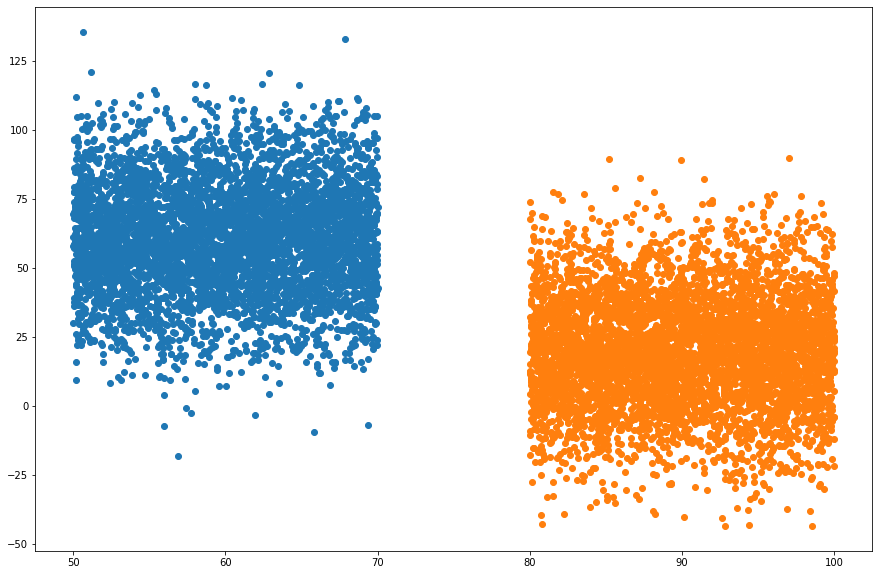

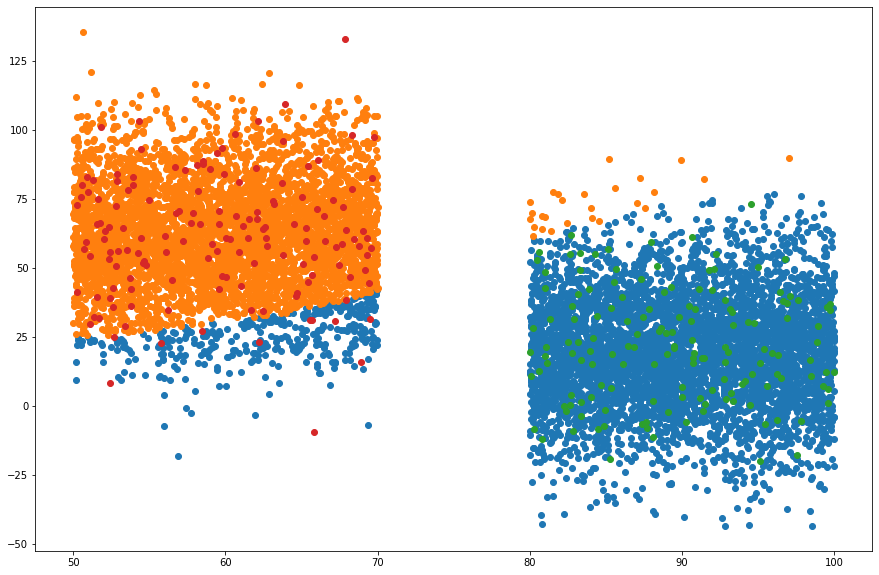

Objective function value =  1.187e+06
Number of iterations = 461
||gr||^2 = 1.53002e-05
CPU time so far =  4.724e+02
Accuracy = 95%


In [ ]:
#Optimality tolerance
eps = 1.0e-10
#Starting point
x = np.zeros(n*2 - labels*2)
#Max iterations
maxit = 10000

y_i,y_j,x_i,x_j = data_generation(n, labels)
#Weights Calculation
w_ij, w_ij_bar = weights(x_i, x_j)
#Hessian and eigv
hessian, eigv, eigv_CPU_time = hessian_matrix_eigv(w_ij, w_ij_bar, y_j)
it, gnrit, timeVec, fh, accuracy,x = gradient_descent_method(eps,x,n,labels,maxit,eigv,w_ij, w_ij_bar,y_i, y_j)
plot_results(x_j,x_i,x,y_i)

print('Objective function value = %10.3e' % (fh[it]));
print('Number of iterations = %d' % it);
print('||gr||^2 = %10.5e' % gnrit[it]);
print('CPU time so far = %10.3e' % timeVec[it]);
print('Accuracy = %d' % (accuracy[it]*100) + '%');

if it<maxit:
    fh[it+1:maxit]=fh[it];
    gnrit[it+1:maxit]=gnrit[it];
    timeVec[it+1:maxit]=timeVec[it];
fmin = min(fh)
timeVec = timeVec + eigv_CPU_time
timeVec[0] = 0

##Randomized BCGD Method


In [ ]:
def randomized_block_coordinate(eps,x,n,labels,maxit,eigv, w_ij, w_ij_bar,y_i, y_j):
  #iteration
  it = 0

  #CPU time for each iteration
  timeVec = np.zeros(maxit)
  #accuracy
  accuracy = np.zeros(maxit)
  #Objective function value at each iteration
  fh = np.zeros(maxit)
  #Starting time
  t = time.time()
  #Lipschitz Constant
  lc = max(eigv)

  while it < maxit:
    t_off = time.time()
    fk = objective_function(w_ij, w_ij_bar,x,y_i)
    fh[it] = fk
    y_j_accuracy = np.array(list(map(lambda x: -1 if x == True else 1, (x<0))))
    accuracy[it] = accuracy_score(y_j_accuracy, y_j)
    t_off_final = time.time() - t_off

    if it==0:
        timeVec[it] = 0
    else:
        timeVec[it] = time.time() - t - t_off_final

    #3.Test for termination
    # Stopping condition: stopping criterion based on sufficient decrease of the objective function
    if abs(fh[it]-fh[it-1])<eps:
      break
    for i in range(n):
      #Index random block
      ind=random.randrange(0,n)
      #4. Compute descent direction dk
      gradient = first_derivative_block(w_ij,w_ij_bar ,x, y_i, ind)
      d = -gradient
      #5.Compute a suitable stepsize alphak > 0 
      #Line search
      alpha=1/lc
      #6.Update
      x[ind]=x[ind]+alpha*d

    it = it + 1
  return it,timeVec,fh,accuracy,x

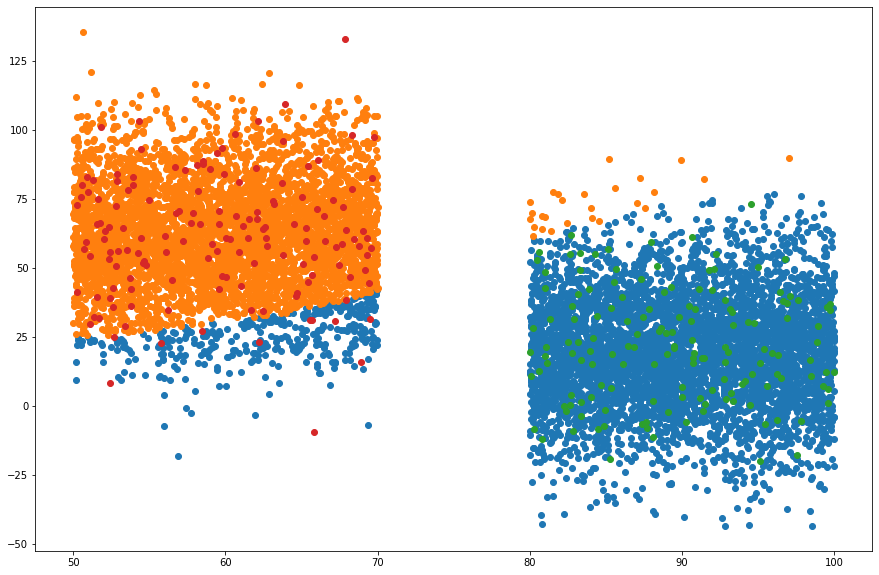

Objective function value =  1.187e+06
Number of iterations = 476
CPU time so far =  5.267e+02
Accuracy = 95%


In [ ]:
#Optimality tolerance
eps = 1.0e-10
#Starting point
x = np.zeros(n*2 - labels*2)
#Max iterations
maxit = 10000

it,timeVecRand,fhRand, accuracy,xRand = randomized_block_coordinate(eps,x,n*2 - labels*2,labels,maxit,eigv,w_ij, w_ij_bar,y_i, y_j)
plot_results(x_j,x_i,xRand,y_i)

if it == maxit:
  it = maxit -1 
print('Objective function value = %10.3e' % (fhRand[it]));
print('Number of iterations = %d' % it);
print('CPU time so far = %10.3e' % timeVecRand[it]);
print('Accuracy = %d' % (accuracy[it]*100) + '%');

if it<maxit:
    fhRand[it+1:maxit]=fhRand[it];
    timeVecRand[it+1:maxit]=timeVecRand[it];
fminRand = min(fhRand)
timeVecRand = timeVecRand + eigv_CPU_time
timeVecRand[0] = 0

##Cyclic BCGD Method


In [ ]:
def cyclic_block_coordinate(eps,x,n,labels,maxit,eigv, w_ij, w_ij_bar,y_i, y_j):
  #iteration
  it = 0
  #CPU time for each iteration
  timeVec = np.zeros(maxit)
  #accuracy
  accuracy = np.zeros(maxit)
  #Objective function value at each iteration
  fh = np.zeros(maxit)
  #Starting time
  t = time.time()
  #Lipschitz Constant
  lc = max(eigv)

  while it < maxit:

    t_off = time.time()
    fk = objective_function(w_ij, w_ij_bar,x,y_i)
    fh[it] = fk
    y_j_accuracy = np.array(list(map(lambda x: -1 if x == True else 1, (x<0))))
    accuracy[it] = accuracy_score(y_j_accuracy, y_j)
    t_off_final = time.time() - t_off

    if it==0:
        timeVec[it] = 0
    else:
        timeVec[it] = time.time() - t - t_off_final

    #3.Test for termination
    # Stopping condition: stopping criterion based on sufficient decrease of the objective function
    if abs(fh[it]-fh[it-1])<eps:
      break
    for i in range(n):
      #4. Compute descent direction dk
      gradient = first_derivative_block(w_ij,w_ij_bar ,x, y_i, i)
      d = -gradient
      #5.Compute a suitable stepsize alphak > 0 
      #Line search
      alpha=1/lc
      #6.Update
      x[i]=x[i]+alpha*d

    it = it + 1
  return it,timeVec,fh,accuracy,x

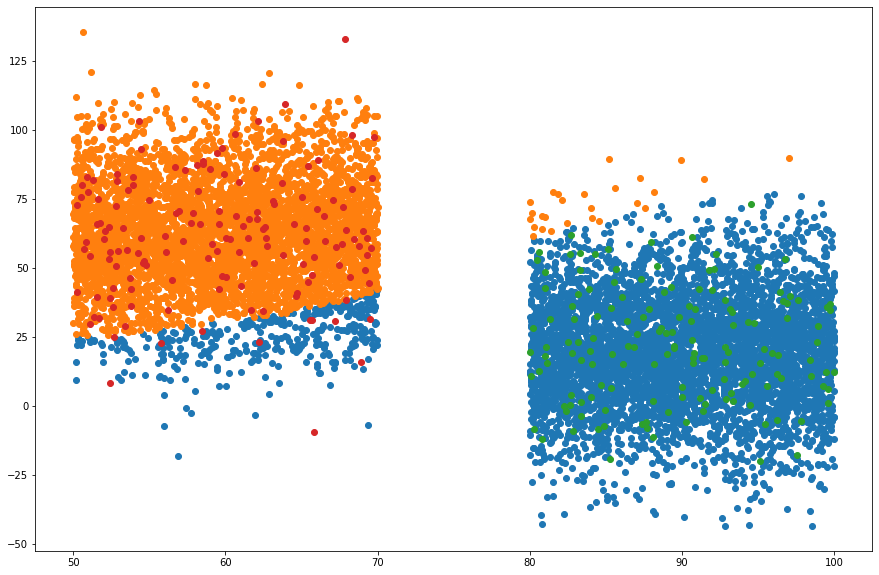

Objective function value =  1.187e+06
Number of iterations = 308
CPU time so far =  3.214e+02
Accuracy = 95%


In [ ]:
#Optimality tolerance
eps = 1.0e-10
#Starting point
x = np.zeros(n*2 - labels*2)
#Max iterations
maxit = 10000

it,timeVecCycl,fhCycl, accuracy,xCycl = cyclic_block_coordinate(eps,x,n*2 - labels*2,labels,maxit,eigv,w_ij, w_ij_bar,y_i, y_j)
plot_results(x_j,x_i,xCycl,y_i)

print('Objective function value = %10.3e' % (fhCycl[it]));
print('Number of iterations = %d' % it);
print('CPU time so far = %10.3e' % timeVecCycl[it]);
print('Accuracy = %d' % (accuracy[it]*100) + '%');

if it<maxit:
    fhCycl[it+1:maxit]=fhCycl[it];
    timeVecCycl[it+1:maxit]=timeVecCycl[it];
fminCycl = min(fhCycl)
timeVecCycl = timeVecCycl + eigv_CPU_time
timeVecCycl[0] = 0

##Plots (Results)

The plots show :
* *Error (Accuracy) vs CPU time*: 
    * The error is calculated as the difference between the **minimum value of the objective function among all iterations** of the optimization process and **the value of the objective function at each iteration of the optimization algorithm.** (fh - fmin)
    * The *CPU time* includes the computation of the Hessian matrix and eigenvalues to obtain the L-constant plus the execution time of the analyzed optimization algorithm by *subtracting the computation of the objective function at each iteration*. 

* *Error (Accuracy) vs iteration*: 
    * The error is calculated as the difference between the **minimum value of the objective function among all iterations** of the optimization process and **the value of the objective function at each iteration of the optimization algorithm.** (fh - fmin) : distance from the minimum at each iteration.
    * Number of iterations to reach the optimality condition.

An extensive and detailed comment about the plots is presented in the final report.

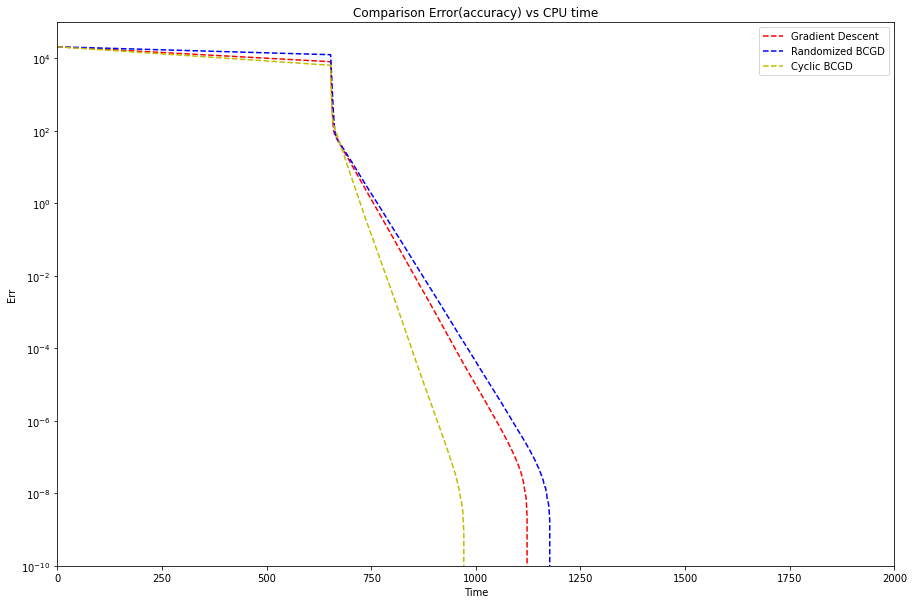

In [ ]:
#Plot figure
#semilogy : Make a plot with log scaling on the y axis.
plt.figure(figsize=(15,10))
plt.semilogy(timeVec, fh - fmin,'r--')
plt.semilogy(timeVecRand, fhRand - fminRand, 'b--')
plt.semilogy(timeVecCycl, fhCycl - fminCycl, 'y--')

plt.legend(['Gradient Descent', 'Randomized BCGD', 'Cyclic BCGD'])


plt.ylim([1e-10,1e5]) 
plt.xlim([0, 2000])
plt.title('Comparison Error(accuracy) vs CPU time')
plt.xlabel('Time')  
plt.ylabel('Err')   
plt.show()

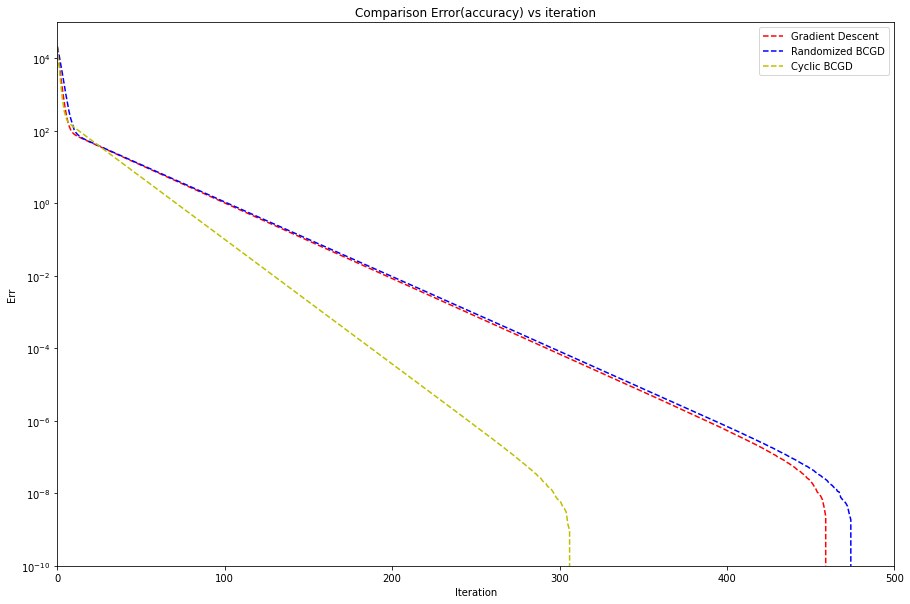

In [ ]:
#Plot figure
#semilogy : Make a plot with log scaling on the y axis.
plt.figure(figsize=(15,10))
plt.semilogy(fh - fmin,'r--')
plt.semilogy(fhRand - fminRand, 'b--')
plt.semilogy(fhCycl - fminCycl, 'y--')

plt.legend(['Gradient Descent', 'Randomized BCGD', 'Cyclic BCGD'])


plt.ylim([1e-10,1e5]) 
plt.xlim([0, 500])
plt.title('Comparison Error(accuracy) vs iteration')
plt.xlabel('Iteration')  
plt.ylabel('Err')   
plt.show()

##External Dataset

https://archive.ics.uci.edu/ml/datasets/banknote+authentication
###Dataset Information:

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

###Attribute Information:

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)



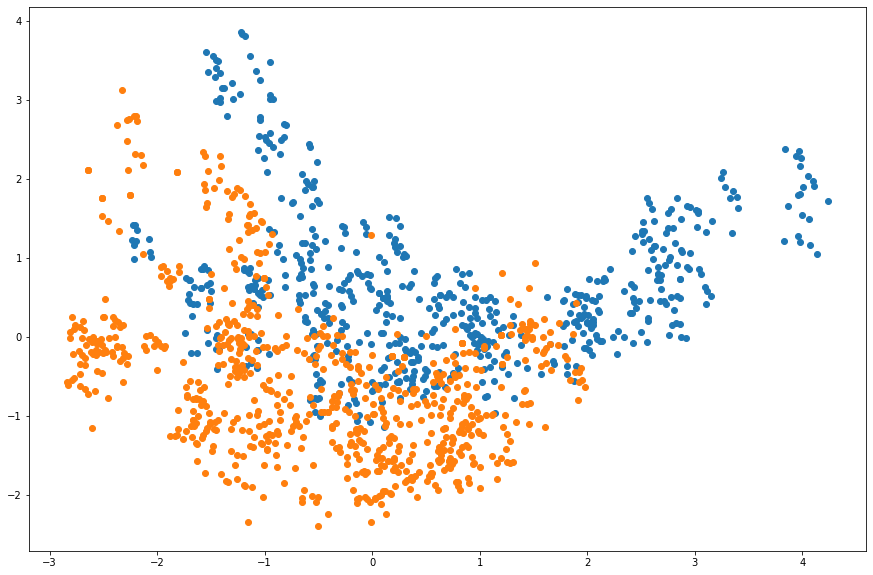

In [ ]:
n,y_i,y_j,x_i,x_j = data_preparation_external_db('/content/data_banknote_authentication.txt', 20)
w_ij, w_ij_bar = weights(x_i, x_j)

In [ ]:
#Optimality tolerance
eps = 1.0e-10
#Max iterations
maxit = 10000

#Starting point
x = np.zeros(n)
#Weights Calculation
#Hessian and eigv
hessian, eigv, eigv_CPU_time = hessian_matrix_eigv(w_ij, w_ij_bar, y_j)
it, gnrit, timeVec, fh, accuracy,x = gradient_descent_method(eps,x,n,labels,maxit,eigv,w_ij, w_ij_bar,y_i, y_j)

print('Objective function value = %10.3e' % (fh[it]));
print('Number of iterations = %d' % it);
print('||gr||^2 = %10.5e' % gnrit[it]);
print('CPU time so far = %10.3e' % timeVec[it]);
print('Accuracy = %d' % (accuracy[it]*100) + '%');

if it<maxit:
    fh[it+1:maxit]=fh[it];
    gnrit[it+1:maxit]=gnrit[it];
    timeVec[it+1:maxit]=timeVec[it];
fmin = min(fh)
timeVec = timeVec + eigv_CPU_time
timeVec[0] = 0

Objective function value =  5.489e+04
Number of iterations = 404
||gr||^2 = 3.45492e-07
CPU time so far =  1.388e+01
Accuracy = 87%


In [ ]:
#Optimality tolerance
eps = 1.0e-10
#Starting point
x = np.zeros(n)
#Max iterations
maxit = 10000

it,timeVecRand,fhRand, accuracy,xRand = randomized_block_coordinate(eps,x,n,labels,maxit,eigv,w_ij, w_ij_bar,y_i, y_j)

if it == maxit:
  it = maxit -1 
print('Objective function value = %10.3e' % (fhRand[it]));
print('Number of iterations = %d' % it);
print('CPU time so far = %10.3e' % timeVecRand[it]);
print('Accuracy = %d' % (accuracy[it]*100) + '%');

if it<maxit:
    fhRand[it+1:maxit]=fhRand[it];
    timeVecRand[it+1:maxit]=timeVecRand[it];
fminRand = min(fhRand)
timeVecRand = timeVecRand + eigv_CPU_time
timeVecRand[0] = 0

Objective function value =  5.489e+04
Number of iterations = 406
CPU time so far =  1.656e+01
Accuracy = 87%


In [ ]:
#Optimality tolerance
eps = 1.0e-10
#Starting point
x = np.zeros(n)
#Max iterations
maxit = 10000

it,timeVecCycl,fhCycl, accuracy,xCycl = cyclic_block_coordinate(eps,x,n,labels,maxit,eigv,w_ij, w_ij_bar,y_i, y_j)

print('Objective function value = %10.3e' % (fhCycl[it]));
print('Number of iterations = %d' % it);
print('CPU time so far = %10.3e' % timeVecCycl[it]);
print('Accuracy = %d' % (accuracy[it]*100) + '%');

if it<maxit:
    fhCycl[it+1:maxit]=fhCycl[it];
    timeVecCycl[it+1:maxit]=timeVecCycl[it];
fminCycl = min(fhCycl)
timeVecCycl = timeVecCycl + eigv_CPU_time
timeVecCycl[0] = 0

Objective function value =  5.489e+04
Number of iterations = 239
CPU time so far =  8.491e+00
Accuracy = 87%


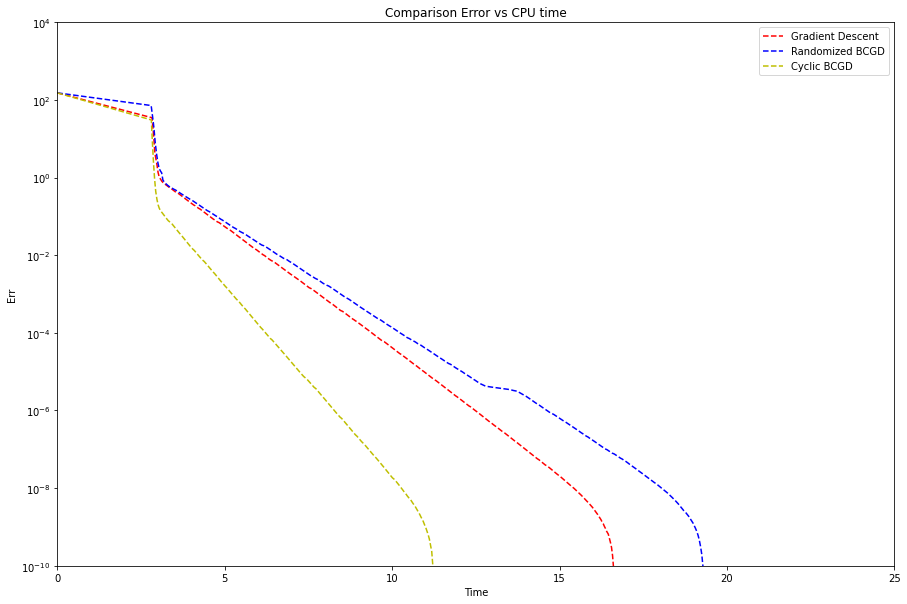

In [ ]:
#Plot figure
#semilogy : Make a plot with log scaling on the y axis.
plt.figure(figsize=(15,10))
plt.semilogy(timeVec, fh - fmin,'r--')
plt.semilogy(timeVecRand, fhRand - fminRand, 'b--')
plt.semilogy(timeVecCycl, fhCycl - fminCycl, 'y--')

plt.legend(['Gradient Descent', 'Randomized BCGD', 'Cyclic BCGD'])


plt.ylim([1e-10,1e4]) 
plt.xlim([0, 25])
plt.title('Comparison Error vs CPU time')
plt.xlabel('Time')  
plt.ylabel('Err')   
plt.show()

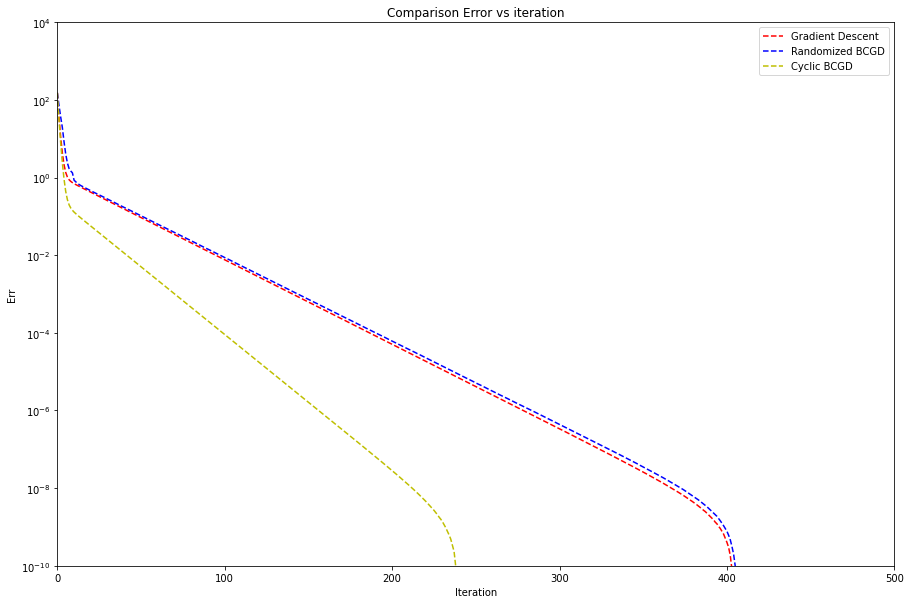

In [ ]:
#Plot figure
#semilogy : Make a plot with log scaling on the y axis.
plt.figure(figsize=(15,10))
plt.semilogy(fh - fmin,'r--')
plt.semilogy(fhRand - fminRand, 'b--')
plt.semilogy(fhCycl - fminCycl, 'y--')

plt.legend(['Gradient Descent', 'Randomized BCGD', 'Cyclic BCGD'])


plt.ylim([1e-10,1e4]) 
plt.xlim([0, 500])
plt.title('Comparison Error vs iteration')
plt.xlabel('Iteration')  
plt.ylabel('Err')   
plt.show()